In [10]:
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import datetime as dt
import pandas as pd
import numpy as np
import os
from datetime import datetime,timedelta
import pylab
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator
from matplotlib.patches import FancyBboxPatch

%matplotlib inline
mpl.rcParams["axes.labelsize"] = 24
mpl.rcParams["axes.titlesize"] = 24
mpl.rcParams["xtick.labelsize"] = 18
mpl.rcParams["ytick.labelsize"] = 22
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["legend.fontsize"] = 17
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["image.cmap"] = "viridis"

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
RESULTS_DIR = os.path.join(ROOT_DIR, "results")
RESULTS_DIR_F = os.path.join(ROOT_DIR, "results_filtered")


In [11]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y) - 1):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag):i])
            stdFilter[i] = np.std(filteredY[(i-lag):i])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

def prepare_topics(dfa,lag,threshold,topic):

    df_transience = dfa.filter(["Transience","Resonance","Novelty"]).resample("D").mean()
    df_topic_only = dfa.filter(["Topic"])
    df_dummy = pd.get_dummies(df_topic_only, columns=['Topic']).resample("D").sum()

    arr = df_dummy.filter([f"Topic_{topic}"]).to_numpy()
    result = thresholding_algo(arr, lag, threshold, influence=0)

    avg_filter = result["avgFilter"]
    threshold_filter = result["avgFilter"] + threshold * result["stdFilter"]
    signals = result["signals"]

    for j in range(0,len(signals)):
        if signals[j] < 1:
            signals[j] = -5
        else:
            signals[j] = arr[j]

    df_transience[f"avg"] = avg_filter
    df_transience[f"threshold"] = threshold_filter
    df_transience[f"signals"] = signals
    df_transience[f"y"] = arr

    return df_transience

def expand_clusters(dataframe, window_size):
    data = dataframe["signals"].replace({-5:0})
    data = data.values.flatten()
    binary_time_series = np.zeros(len(data))
    for i in range(len(data) - window_size + 1):
        window = data[i:i+window_size]
        if np.count_nonzero(window) >= 1:
            binary_time_series[i:i+window_size] = 1
    df = dataframe.copy()
    df["clusters"] = binary_time_series
    
    return df

In [12]:
def line_plot_transience(df, title, topic, lag, threshold, window,count):

    df_ntr_davg = df.query(f"Topic == {topic}").filter(["Transience","Resonance","Novelty"]).resample("D").mean()

    filtered_topics = prepare_topics(df,lag,threshold,topic)
    clusters = expand_clusters(filtered_topics, window)

    fig, ax = plt.subplots(figsize=(25, 3.5))

    ax.locator_params(axis="x", nbins=12)
    beginning = dt.date(2022, 1, 1)
    end = dt.date(2023, 1, 1)
    ax2 = ax.twinx()

    ax.plot(filtered_topics.index.values, filtered_topics["y"], color='grey', linewidth=1, alpha=1)

    df_ntr_davg.loc[clusters["clusters"]==0, 'Transience'] = np.nan
    df_ntr_davg.loc[clusters["clusters"]==0, 'Resonance'] = np.nan
    df_ntr_davg.loc[clusters["clusters"]==0, 'Novelty'] = np.nan
    novelty = df_ntr_davg["Novelty"]
    resonance = df_ntr_davg["Resonance"]
    transience = df_ntr_davg["Transience"]

    ax2.step(df_ntr_davg.index.values, novelty, c="green", lw=0.8)
    ax2.step(df_ntr_davg.index.values, transience, c="red", lw=0.8)
    # ax2.step(df_ntr_davg.index.values, resonance, c="blue",lw=0.8)

    ax.set(
        title=title,
        xbound=(beginning, end),
        ylabel="Topic Counts"
    )

    ybox1 = TextArea("Transience", textprops=dict(color="r", size=24,rotation=270,ha='right',va='bottom'))
    ybox3 = TextArea("Novelty", textprops=dict(color="g", size=24,rotation=270,ha='right',va='bottom'))
    ybox1 = VPacker(children=[ybox1],align="bottom", pad=0, sep=5)
    ybox2 = VPacker(children=[ybox3],align="bottom", pad=0, sep=5)
    anchored_ybox1 = AnchoredOffsetbox(loc="right", child=ybox1, pad=0., frameon=False, bbox_to_anchor=(1.07, 0.453), 
                                    bbox_transform=ax.transAxes, borderpad=0.)
    anchored_ybox2 = AnchoredOffsetbox(loc="right", child=ybox2, pad=0., frameon=False, bbox_to_anchor=(1.05, 0.453), 
                                    bbox_transform=ax.transAxes, borderpad=0.)
    ax.add_artist(anchored_ybox1)
    ax.add_artist(anchored_ybox2)
        
    date_form = DateFormatter("%b-%y")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(date_form)
    start, end = ax.get_ylim()
    ax2.yaxis.set_major_locator(LinearLocator(5))
    ax2.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_locator(LinearLocator(5))
    yticks = ax.get_yticks()
    yticks[0] = 0
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ticks = [tick for tick in ax.xaxis.get_majorticklabels()]
    ticks[0].set_horizontalalignment("left")
    ticks[-1].set_horizontalalignment("right")

    return fig

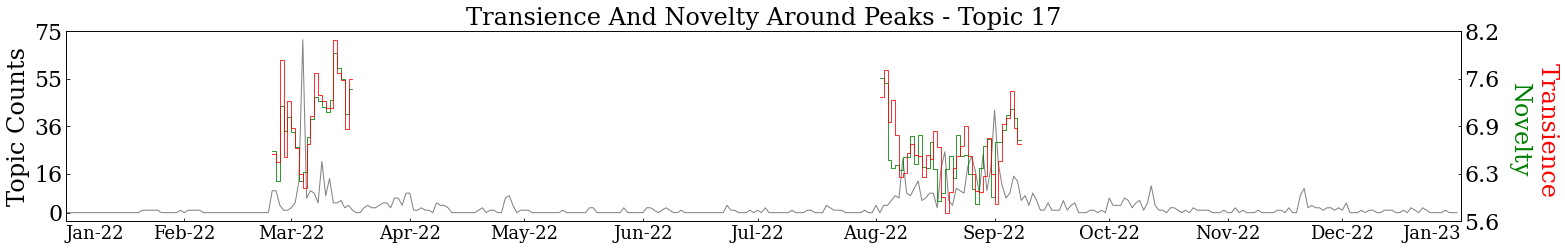

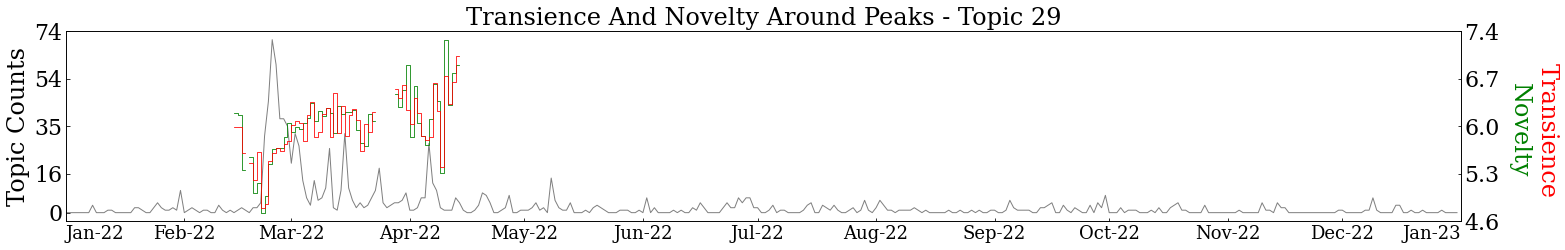

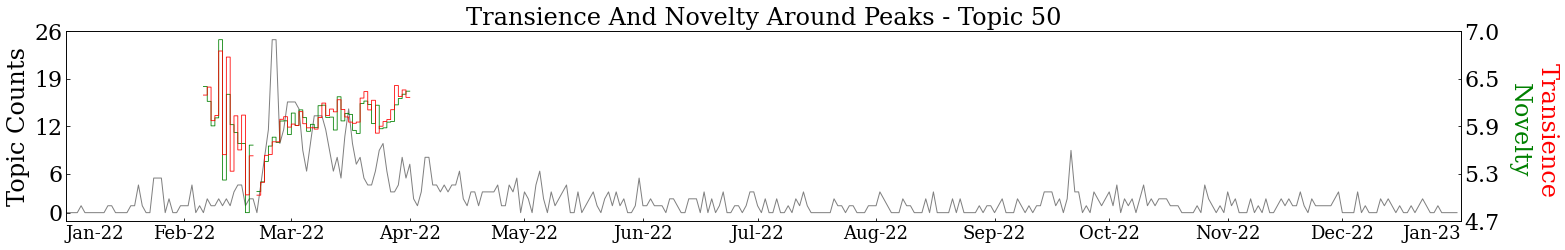

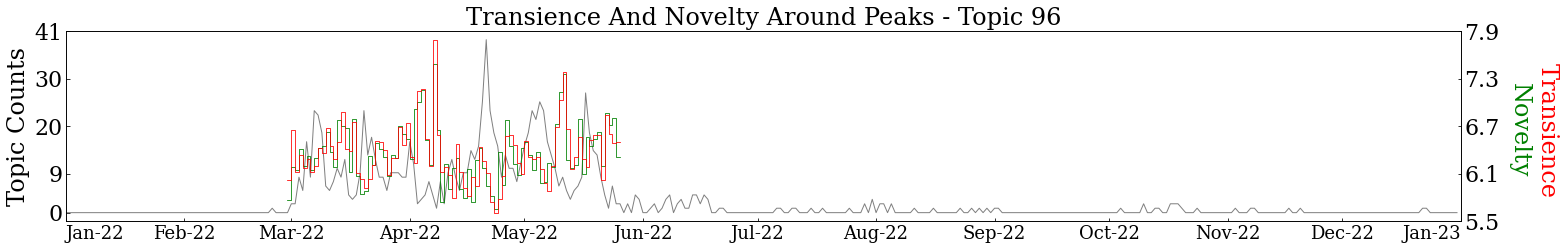

In [13]:
dips_kwargs = {
    # 10:{"lag":300,"threshold":5,"window":10,"count":1,}, #
    17:{"lag":240,"threshold":6,"window":7,"count":1}, #
    29:{"lag":235,"threshold":9,"window":9,"count":1}, #
    50:{"lag":235,"threshold":6,"window":17,"count":1}, #
    # 55:{"lag":270,"threshold":10,"window":8,"count":5}, #
    # 59:{"lag":238,"threshold":5,"window":20,"count":1}, #
    96:{"lag":247,"threshold":5,"window":10,"count":1}, #
    # 3:{"lag":300,"threshold":5,"window":15,"count":1},
    # 4:{"lag":235,"threshold":5,"window":15,"count":1},s
    # 7:{"lag":300,"threshold":5,"window":15,"count":1},
    # 18:{"lag":243,"threshold":5,"window":15,"count":1},
    # 20:{"lag":290,"threshold":5,"window":15,"count":1},
    # 22:{"lag":240,"threshold":7,"window":15,"count":1},
    # 24:{"lag":230,"threshold":6,"window":15,"count":1},
    # 35:{"lag":195,"threshold":2,"window":15,"count":1},
    # 57:{"lag":238,"threshold":6,"window":15,"count":1},
    # 63:{"lag":445,"threshold":8,"window":15,"count":1},
    # 65:{"lag":230,"threshold":6,"window":15,"count":1},
    # 73:{"lag":240,"threshold":6,"window":15,"count":1},
    # 81:{"lag":238,"threshold":14,"window":15,"count":1},
    # 86:{"lag":270,"threshold":6,"window":15,"count":1},
    # 99:{"lag":240,"threshold":5,"window":15,"count":1},
}

for topic in dips_kwargs.keys():
    df = pd.read_csv(os.path.join(ROOT_DIR, "results_1", "All_Results.csv"), parse_dates=["Date"], index_col=["Date"])
    fig4 = line_plot_transience(df, f"Transience And Novelty Around Peaks - Topic {topic}", topic, **dips_kwargs[topic])
    fig4.savefig(os.path.join(ROOT_DIR, "figures","peaks_ntr_overlay", f"peak_detection_ntr_topic_{topic}.svg"), format="svg", dpi=1000, bbox_inches="tight")